## CSCN8030 - Artificial Intelligence for Business Decisions and Transformation
### Sprint 2 - Airbnb

Group 6:

Rohit Totlani - 8914803

Pradeepti Kasam - 8965985

Mohammed Benkhial -8928209

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

In [2]:
abnb_df = pd.read_csv('Airbnb_dataset/AB_NYC_2019.csv')
abnb_df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


**EDA**

In [3]:
print("Number of rows: ", abnb_df.shape[0])
print("Number of columns: ", abnb_df.shape[1])

Number of rows:  48895
Number of columns:  16


**Price Distribution**

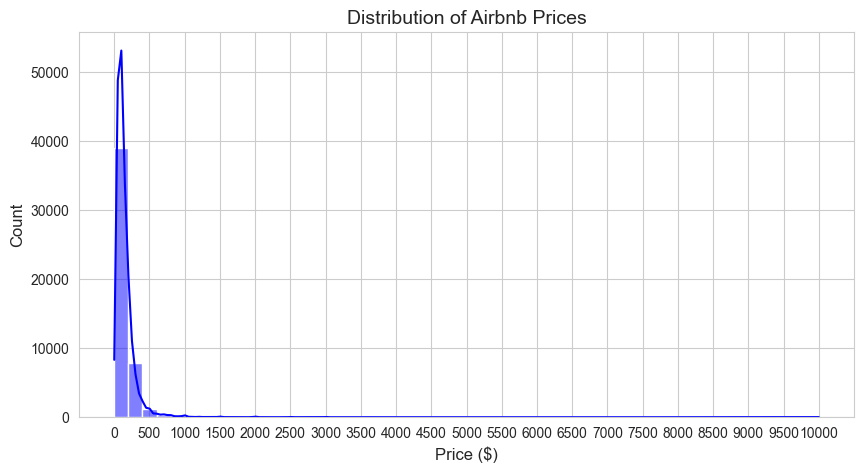

In [4]:
# Set style
sns.set_style("whitegrid")

# Plot price distribution (log scale to handle outliers)
plt.figure(figsize=(10, 5))
sns.histplot(abnb_df['price'], bins=50, kde=True, color="blue")
plt.title("Distribution of Airbnb Prices", fontsize=14)
plt.xlabel("Price ($)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(range(0, int(abnb_df['price'].max()) + 500, 500))
plt.show()

Most listings are under $500.

**availability distribution**

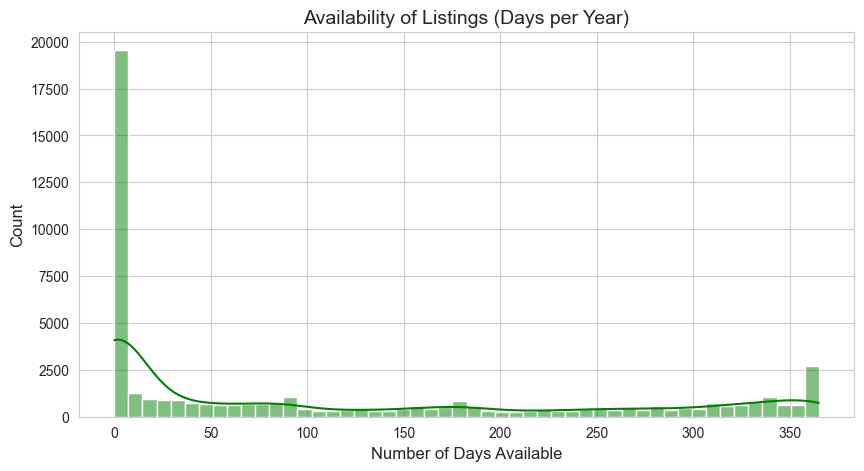

In [5]:
# Plot availability distribution
plt.figure(figsize=(10, 5))
sns.histplot(abnb_df['availability_365'], bins=50, kde=True, color="green")
plt.title("Availability of Listings (Days per Year)", fontsize=14)
plt.xlabel("Number of Days Available", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

large number of listings are available for fewer than 100 days per year. 

**Top Hosts**

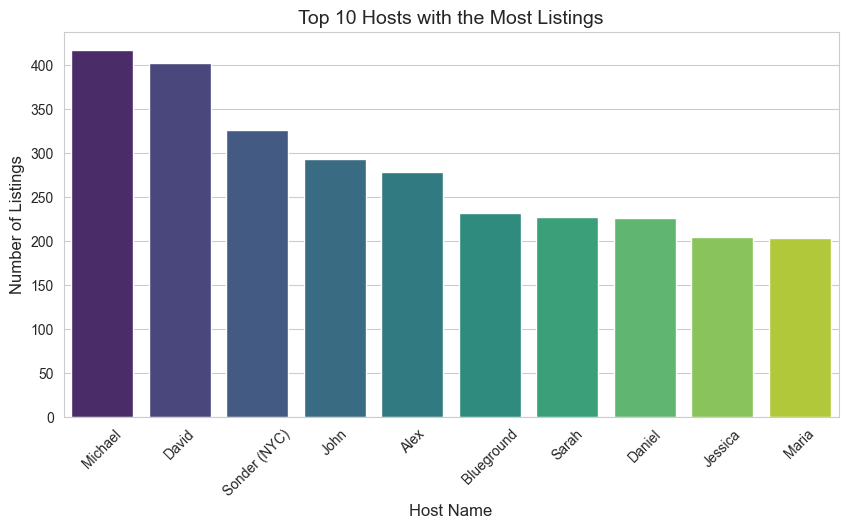

In [6]:
# Top 10 hosts with the most listings
top_hosts = abnb_df['host_name'].value_counts().head(10)

# Plot top hosts with the most listings
plt.figure(figsize=(10, 5))
sns.barplot(x=top_hosts.index, y=top_hosts.values, palette="viridis", hue = top_hosts.index)
plt.title("Top 10 Hosts with the Most Listings", fontsize=14)
plt.xlabel("Host Name", fontsize=12)
plt.ylabel("Number of Listings", fontsize=12)
plt.xticks(rotation=45)
plt.show()

Some hosts like Michael, David manage hundreds of listings, indicating professional property management.

**Listings Per Neighbourhood**

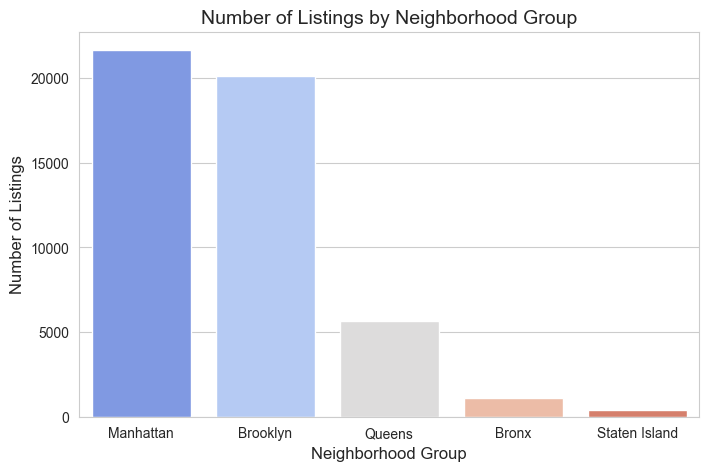

In [7]:
# Number of listings by neighborhood group
neighborhood_counts = abnb_df['neighbourhood_group'].value_counts()

# Plot number of listings by neighborhood group
plt.figure(figsize=(8, 5))
sns.barplot(x=neighborhood_counts.index, hue=neighborhood_counts.index, y=neighborhood_counts.values, palette="coolwarm")
plt.title("Number of Listings by Neighborhood Group", fontsize=14)
plt.xlabel("Neighborhood Group", fontsize=12)
plt.ylabel("Number of Listings", fontsize=12)
plt.show()

Manhattan and Brooklyn dominate Airbnb listings.

Queens, Bronx, and Staten Island have significantly fewer listings.

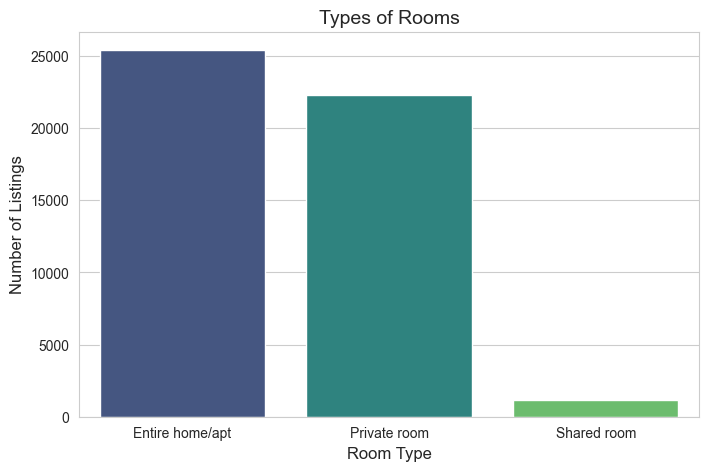

In [8]:
#Plot types of rooms
room_types = abnb_df['room_type'].value_counts()
plt.figure(figsize=(8, 5))
sns.barplot(x=room_types.index, y=room_types.values, palette="viridis", hue = room_types.index)
plt.title("Types of Rooms", fontsize=14)
plt.xlabel("Room Type", fontsize=12)
plt.ylabel("Number of Listings", fontsize=12)
plt.show()

Most of properties listed are Entire home/apt followed by a private room with a negligent number of shared rooms

In [9]:
abnb_df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [10]:
#identify columns with missing values
for col in abnb_df.columns:
    if abnb_df[col].isnull().sum() > 0:
        if abnb_df[col].dtype == 'object':
            abnb_df[col] = abnb_df[col].fillna('NA')
        else:
            abnb_df[col] = abnb_df[col].fillna(0)


**Decision support System for Hosts**

I chose Hosts as the primary stakeholder for the DSS because they can directly benefit from data-driven insights to optimize pricing, maximize occupancy, and stay competitive.

**Dynamic Pricing Model: Suggests the best price based on location, seasonality, and competition.**

In [11]:
#outlier detection using IQR
Q1 = abnb_df['price'].quantile(0.25)
Q3 = abnb_df['price'].quantile(0.75)
IQR = Q3 - Q1
print("IQR: ", IQR)

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("Lower bound: ", lower_bound)
print("Upper bound: ", upper_bound)

outliers = abnb_df[(abnb_df['price'] < lower_bound) | (abnb_df['price'] > upper_bound)]
print("Number of outliers: ", outliers.shape[0])

IQR:  106.0
Lower bound:  -90.0
Upper bound:  334.0
Number of outliers:  2972


In [12]:
#handling the outliers by capping the price
abnb_df['price'] = abnb_df['price'].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)

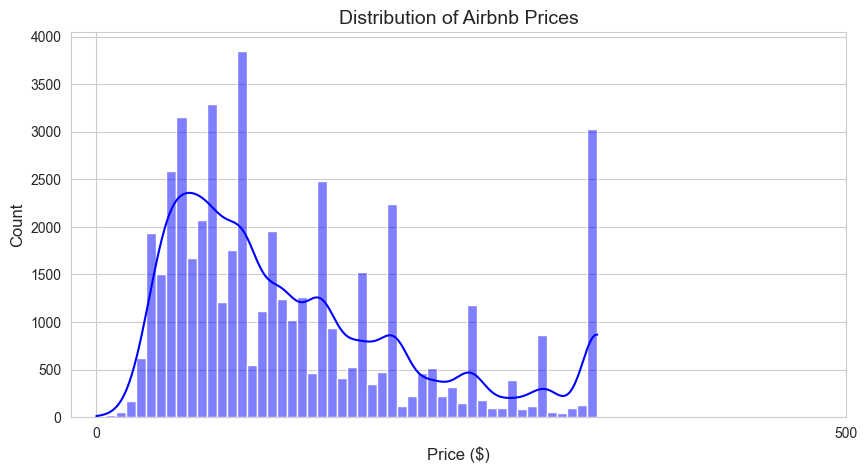

In [13]:
# Plot price distribution after handling outliers
plt.figure(figsize=(10, 5))
sns.histplot(abnb_df['price'], bins=50, kde=True, color="blue")
plt.title("Distribution of Airbnb Prices", fontsize=14)
plt.xlabel("Price ($)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(range(0, int(abnb_df['price'].max()) + 500, 500))
plt.show()

**Extracting essential columns**

In [14]:
essential_columns = ['neighbourhood_group', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
#'latitude', 'latitude'
abnb_df_modified = abnb_df[essential_columns]

abnb_df_modified.head()

,neighbourhood_group,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Private room,149.0,1,9,0.21,6,365
1,Manhattan,Entire home/apt,225.0,1,45,0.38,2,355
2,Manhattan,Private room,150.0,3,0,0.00,1,365
3,Brooklyn,Entire home/apt,89.0,1,270,4.64,1,194
4,Manhattan,Entire home/apt,80.0,10,9,0.10,1,0


In [15]:
#one hot encoding for categorical variables
abnb_df_modified = pd.get_dummies(abnb_df_modified, columns=['neighbourhood_group', 'room_type'])

In [16]:
abnb_df_modified.head()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,149.0,1,9,0.21,6,365,False,True,False,False,False,False,True,False
1,225.0,1,45,0.38,2,355,False,False,True,False,False,True,False,False
2,150.0,3,0,0.00,1,365,False,False,True,False,False,False,True,False
3,89.0,1,270,4.64,1,194,False,True,False,False,False,True,False,False
4,80.0,10,9,0.10,1,0,False,False,True,False,False,True,False,False


Splitting Data in 80 :20 Train, test ratio

In [17]:
# Define features (X) and target (y)
X = abnb_df_modified.drop('price', axis=1)
y = abnb_df_modified['price']

# Split the data (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (39116, 13)
Testing data shape: (9779, 13)


**Linear Regression Model**

In [18]:
# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred = lr_model.predict(X_test)

In [19]:
# Calculate the Mean Squared Error (MSE) and R-squared score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = lr_model.score(X_test, y_test)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

print(f"Accuracy: {(accuracy*100): .2f}%")

Mean Squared Error (MSE): 3832.4225927616817
R-squared (R2): 0.44284412350747215
Accuracy:  44.28%


**Linear Regression Model with Feature Selection**

In [21]:
from sklearn.feature_selection import RFE
selector = RFE(lr_model, n_features_to_select=13)  # Select top 10 features
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)

lr_model.fit(X_train_selected, y_train)

#accuracy
accuracy_selected = lr_model.score(X_test_selected, y_test)
print(f"Accuracy: {(accuracy_selected*100): .2f}%")

#MSE
y_pred_selected = lr_model.predict(X_test_selected)
mse_selected = mean_squared_error(y_test, y_pred_selected)
print(f"Mean Squared Error (MSE): {mse_selected}")

#R2_Score
r2_selected = r2_score(y_test, y_pred_selected)
print(f"R-squared (R2): {r2_selected}")


Accuracy:  44.28%
Mean Squared Error (MSE): 3832.4225927616817
R-squared (R2): 0.44284412350747215


**Polynomial Regression**

In [24]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

lr_model.fit(X_train_poly, y_train)
y_pred_poly = lr_model.predict(X_test_poly)

#accuracy
accuracy_poly = lr_model.score(X_test_poly, y_test)
print(f"Accuracy: {(accuracy_poly*100): .2f}%")

#MSE
mse_poly = mean_squared_error(y_test, y_pred_poly)
print(f"Mean Squared Error (MSE): {mse_poly}")

#R2_Score
r2_poly = r2_score(y_test, y_pred_poly)
print(f"R-squared (R2): {r2_poly}")

Accuracy:  47.68%
Mean Squared Error (MSE): 3599.1551002682336
R-squared (R2): 0.4767564468725597


**Random Forest Model**

In [25]:
# Initialize and train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, random_state=42)

In [26]:
# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Calculate the Mean Squared Error (MSE), R-squared score, and accuracy
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f"Mean Squared Error (MSE): {mse_rf}")

r2_rf = r2_score(y_test, y_pred_rf)
print(f"R-squared (R2): {r2_rf}")

accuracy_rf = rf_model.score(X_test, y_test)
print(f"Accuracy: {(accuracy_rf*100): .2f}%")

Mean Squared Error (MSE): 3673.6704973812607
R-squared (R2): 0.46592343188378726
Accuracy:  46.59%


**Hypertuning Parameters using GridSearchCV**

In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, n_jobs=-1, verbose=2)
rf_grid.fit(X_train, y_train)

print("Best Params: ", rf_grid.best_params_)
rf_model = rf_grid.best_estimator_


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Params:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 500}


In [28]:
#accuracy
accuracy_grid = rf_model.score(X_test, y_test)
print(f"Accuracy: {(accuracy_grid*100): .2f}%")

#MSE
y_pred_grid = rf_model.predict(X_test)
mse_grid = mean_squared_error(y_test, y_pred_grid)
print(f"Mean Squared Error (MSE): {mse_grid}")

#R2
r2_grid = r2_score(y_test, y_pred_grid)
print(f"R-squared (R2): {r2_grid}")


Accuracy:  51.28%
Mean Squared Error (MSE): 3351.5367218120623
R-squared (R2): 0.5127550955980359


**XGBoost Model**

In [30]:
#xgboost
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, n_jobs=-1)
xgb_model.fit(X_train, y_train)

#accuracy
accuracy_xgb = xgb_model.score(X_test, y_test)
print(f"Accuracy: {(accuracy_xgb*100): .2f}%")

#MSE
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print(f"Mean Squared Error (MSE): {mse_xgb}")

#R2
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"R-squared (R2): {r2_xgb}")


Accuracy:  51.46%
Mean Squared Error (MSE): 3339.1295978937296
R-squared (R2): 0.5145588377047978


**Inspiration**

**What can we learn about different hosts and areas?**

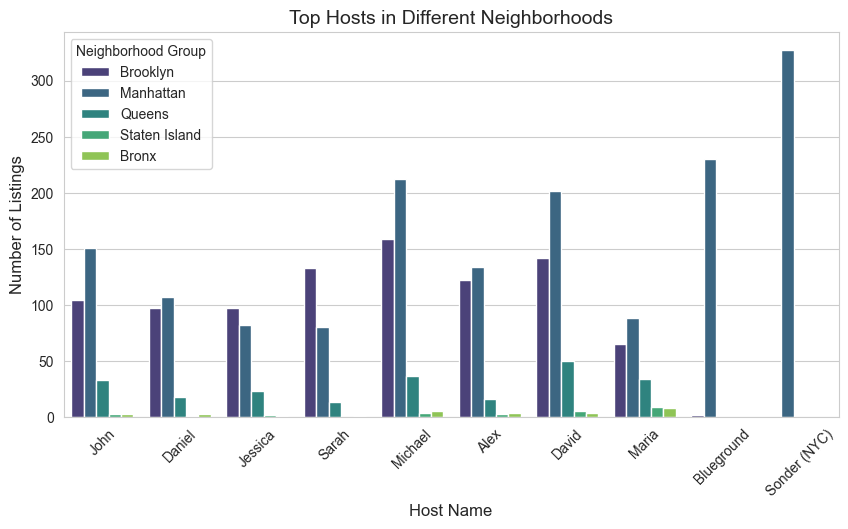

In [31]:
#What can we learn about different hosts and areas

#bar graph to determine relation between hosts and areas
top_hosts = abnb_df['host_name'].value_counts().head(10)
top_hosts_df = abnb_df[abnb_df['host_name'].isin(top_hosts.index)]
plt.figure(figsize=(10, 5))
sns.countplot(data=top_hosts_df, x='host_name', hue='neighbourhood_group', palette='viridis')
plt.title("Top Hosts in Different Neighborhoods", fontsize=14)
plt.xlabel("Host Name", fontsize=12)
plt.ylabel("Number of Listings", fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Neighborhood Group')
plt.show()


- large property management companies operate more listings in Manhattan.

- Several hosts have a significant number of listings in Brooklyn (purple), second only to Manhattan.

- Airbnb activity is less concentrated in Queens, Staten Island, and Bronx.

- The highest number of listings belong to Sonder (NYC) and Blueground, which are well-known corporate Airbnb operators.

- Investors may want to focus on Manhattan and Brooklyn, as they have the highest number of listings.

**What can we learn from predictions? (ex: locations, prices, reviews, etc)**

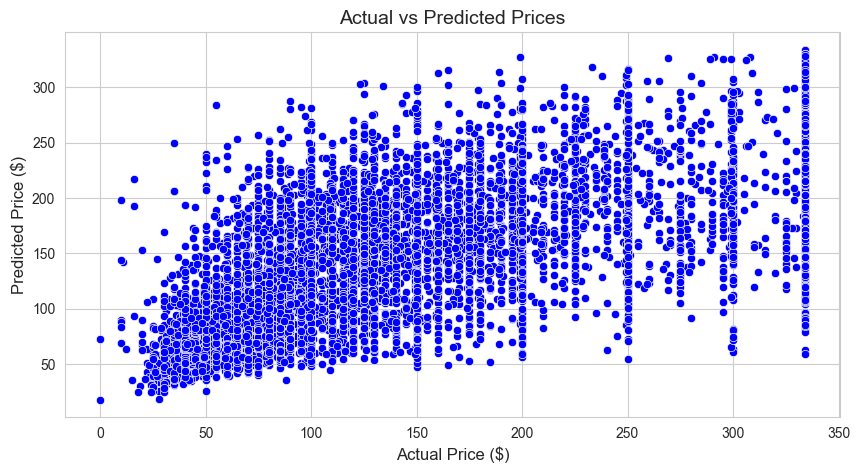

In [40]:
#What can we learn from predictions

#scatter plot to determine relation between actual and predicted values 
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_test, y=y_pred_rf, color='blue')
plt.title("Actual vs Predicted Prices", fontsize=14)
plt.xlabel("Actual Price ($)", fontsize=12)
plt.ylabel("Predicted Price ($)", fontsize=12)
plt.show()

- There is a clear upward trend, indicating that as actual prices increase, predicted prices also tend to increase.

- The spread of points suggests that predictions are not perfectly aligned with actual values.

- The model appears to underestimate high actual prices, as many high-priced listings (above $200) have predicted values significantly lower.

- For low actual prices (under $50), some predicted prices seem to be higher than actual values, meaning the model is overestimating cheaper listings.

**Which hosts are the busiest and why?**

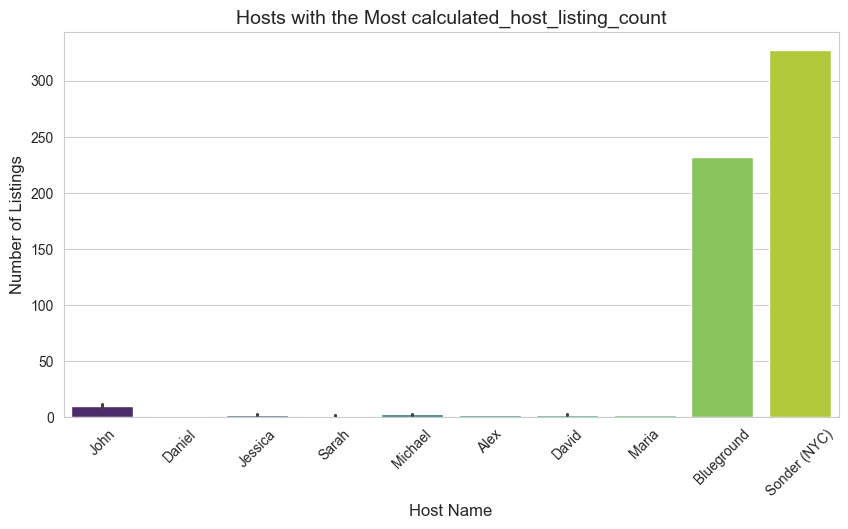

In [39]:
#bar graph to determine relation between hosts and calculated host listings count

top_hosts = abnb_df['host_name'].value_counts().head(10)
top_hosts_df = abnb_df[abnb_df['host_name'].isin(top_hosts.index)]
plt.figure(figsize=(10, 5))
sns.barplot(data=top_hosts_df, x='host_name',hue='host_name', y='calculated_host_listings_count', palette='viridis')
plt.title("Hosts with the Most calculated_host_listing_count", fontsize=14)
plt.xlabel("Host Name", fontsize=12)
plt.ylabel("Number of Listings", fontsize=12)
plt.xticks(rotation=45)
plt.show()


- The most busiest hosts based on the number of listings they manage are 

  Sonder (NYC) – 327 listings

  Blueground – 232 listings
  

- Sonder & Blueground: These are professional property management companies specializing in short-term rentals.

- Prime Locations: These hosts likely operate in high-demand areas such as Manhattan.


**Is there any noticeable difference of traffic among different areas and what could be the reason for it?**

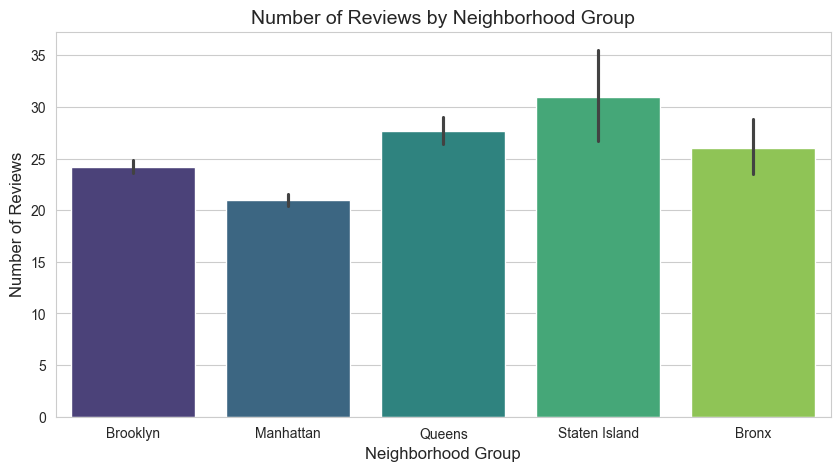

In [ ]:
#bar graph to determine relation between neighborhood group and number of reviews
plt.figure(figsize=(10, 5))
sns.barplot(data=abnb_df, x='neighbourhood_group',hue='neighbourhood_group', y='number_of_reviews', palette='viridis')
plt.title("Number of Reviews by Neighborhood Group", fontsize=14)
plt.xlabel("Neighborhood Group", fontsize=12)
plt.ylabel("Number of Reviews", fontsize=12)
plt.show()


- Manhattan is a prime tourist hub with expensive accommodations, which might lead to fewer bookings per listing despite high foot traffic. Luxury stays often have fewer but more exclusive reviews.

- Brooklyn is popular among younger travelers and digital nomads, leading to moderate but steady review counts.
Price Sensitivity:

- Staten Island may attract budget-conscious travelers, resulting in longer stays and more reviews per booking. Its affordability compared to Manhattan could explain the higher review counts.

- Queens has a mix of affordable listings and proximity to airports (JFK, LaGuardia), attracting transient visitors who leave quick reviews.

- Bronx may have fewer listings overall, but those available might cater to niche markets or long-term stays, boosting review numbers.